# Group Assignment: Statistical Data Analysis
#### Group 7:
 - Aggarwal, Brahm, b3aggarw
 - Chellamuthu, Shanmuga, spchella
 - Mammadov, Rashad, r2mammad
 - Mazloomi, Rod, rmazloom
 - Sanchez, Monica, m7sanche
 - Sheikh, Hassan, h25sheik 

### Introduction

#### Research quesion

We will be exploring the following quesitons:
 - What factors are more important for national happiness? 
 - Are these factors constant over time?
 - How happiness changes over time? 

#### Data

We will use data from the World Happiness Report found in kaggle:
 - https://www.kaggle.com/unsdsn/world-happiness

The World Happiness Report is a publication of the Sustainable Development Solutions Network, that was launched in 2012 and has been published annually till 2020, excluding 2014. The Report uses data from the Gallup World Poll and ranks countries by how happy their citizens perceive themselves. The rankings are based on responses to the main life evaluation questions from nationaly representative samples, in which participants are asked to rate their lives on a 0 (worst possible life) to 10 (best possible life) scale. These rankings are stablished in comparison to Dystopia, an imaginary county with the world’s least-happy people among the main six key variables. The results from the reports have been used by goverments and organizations to make policy decisions and assess the progress and well-being of nations. 

kaggle's dataset includes data from the 2015-19 waves of the World Happiness Report. Each wave contains the national happiness score and the country ranking. Additionally, the dataset contains the contribution to happiness evaluation from each of the six main factors: levels of GDP, life expectancy, generosity, social support, freedom, and corruption. The dataset also includes a variable called ‘Dystopia residual’, that reflects the extent to which the six main factors over- or under-explain the average 2014-2016 life evaluations.  

### Data preparation

In [96]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

In [120]:
# display options
pd.options.display.float_format = "{:.3f}".format

Before importing the data, we edited the colum names in the individual csv files to ensure consistency across files. This allowed us to import only the columns of interestt, i.e. the country and its region, its hapiness ranking, its hapiness score, the contribution to hapiness from each of the six main factors, and the Dystopia residual. With consistent names for variables, we were able to combine the individual csv files into a single data frame, which requiered us to create an additional variable to indicate the year to which the data refered to. As the Report measures countrys' hapiness over time, our resulting data frame is of panel type. 

In [2]:
# import the data of interest
frames = []
col_list = ['Country','Region','Happiness Rank','Happiness Score',
            'Economy (GDP per Capita)','Family','Health (Life Expectancy)',
            'Freedom','Trust (Government Corruption)','Generosity','Dystopia Residual']

for year in range(2015,2020):
    df = pd.read_csv('datasets_894_813759_{:.0f}.csv'.format(year),
                     usecols=lambda col: col in set(col_list))
    df.insert(0,'Year',year)
    frames.append(df)
    
# concatenate frames
data = pd.concat(frames, sort=False)

In [3]:
# visualize the data
data.head()

,Year,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,2015,Switzerland,Western Europe,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,2015,Iceland,Western Europe,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,2015,Denmark,Western Europe,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,2015,Norway,Western Europe,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,2015,Canada,North America,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [4]:
# understand the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 0 to 155
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           782 non-null    int64  
 1   Country                        782 non-null    object 
 2   Region                         315 non-null    object 
 3   Happiness Rank                 782 non-null    int64  
 4   Happiness Score                782 non-null    float64
 5   Economy (GDP per Capita)       782 non-null    float64
 6   Family                         782 non-null    float64
 7   Health (Life Expectancy)       782 non-null    float64
 8   Freedom                        782 non-null    float64
 9   Trust (Government Corruption)  781 non-null    float64
 10  Generosity                     782 non-null    float64
 11  Dystopia Residual              470 non-null    float64
dtypes: float64(8), int64(2), object(2)
memory usage: 7

Our data has 782 rows and 12 columns. All our data is of numeric type, except the country and the region which are text. Our data contains a large amount of missing values for the region and the Dystopia residual. There is also one missing value in the Trust measure. Because the region to which a country belongs is time invariant, we fill the region missing values using the avilable data.   

In [5]:
# check whether there are spelling mistakes for the country and region
for var in ('Country','Region'):
    list1 = data[var].dropna().unique()
    list1.sort()
    print('{:}_list ({:} unique vals) = {:}'.format(var,len(list1),list1))

Country_list (170 unique vals) = ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo (Brazzaville)' 'Congo (Kinshasa)'
 'Costa Rica' 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Djibouti'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia' 'Ethiopia'
 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Guatemala' 'Guinea' 'Haiti' 'Honduras' 'Hong Kong'
 'Hong Kong S.A.R., China' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran'
 'Iraq' 'Ireland' 'Israel' 'Italy' 'Ivory Coast' 'Jamaica' 'Japan'
 'Jordan' 'Kazakhstan' 'Kenya' 'Kosovo' 'Kuwait' 'Kyrgyzstan' 'Laos'
 'Latvia' 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Lithuania' 'Luxembourg'
 '

In [6]:
# make countries names consistent across the dataset
data.Country.replace({'Hong Kong S.A.R., China':'Hong Kong',
                      'Trinidad & Tobago':'Trinidad and Tobago',
                      'North Cyprus':'Northern Cyprus',
                      'North Macedonia':'Macedonia',
                      'Taiwan Province of China':'Taiwan'},inplace=True)
data.Country.nunique()

165

In [7]:
# create a dictionary for region and country
dic = {}
for reg in data['Region'].dropna().unique():
    dic[reg] = data[['Region','Country']].groupby('Region').get_group(reg)['Country'].unique()

In [8]:
# fill region nan values using the dictionary
for row in range(0,len(data.Country)):
    if data.isnull().iloc[row,2]:
        for key, val in dic.items():
            for j in range(0,len(val)):
                if data.iloc[row,1] == val[j]:
                    data.iloc[row,2] = key

#check for missing values
data.Region.isna().sum()

1

After mapping the region to each specific country using the available data, we still have one missing observation for the region variable. We explore which country was not assigned a region under the mapping and input it manually besed on its geographical location.

In [9]:
# explore which countries are still missing a region
data.Country[data.Region.isna()]

119    Gambia
Name: Country, dtype: object

In [10]:
# input missing regions manually
data.Region[data.Country=='Gambia'] = 'Sub-Saharan Africa'

C:\Users\trmo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The Dystopia residual is another variable that has a large amount of missing values. We address these using the fact thatthe happiness score is equivalent to the sum of the contribution from each of the 6 major factors and that of the Dystopia residual. We check that this holds in our data and investigate whether the differences are due to reounding errors.

In [11]:
# sum the components
data['HS_sum'] = data.iloc[:,5:12].sum(axis=1,skipna=False)
                    
# compare the hapiness score and the sum of the contributions
data['HS_match'] = (round(data['HS_sum'],3)==round(data['Happiness Score'],3))

# share of true and false, when dystopia residual is not null
data.groupby('HS_match')['Dystopia Residual'].count()

HS_match
False      2
True     468
Name: Dystopia Residual, dtype: int64

There are only 2 cases for which the sum of the components does not match the happiness score, we explore those individualy.

In [12]:
data.groupby('HS_match').get_group(False).dropna()

,Year,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,HS_sum,HS_match
14,2015,United States,North America,15,7.119,1.39451,1.24711,0.86179,0.54604,0.15890,0.40105,2.51011,7.11951,False
80,2016,Azerbaijan,Central and Eastern Europe,81,5.291,1.12373,0.76042,0.54504,0.35327,0.17914,0.05640,2.27350,5.29150,False


We can see that for the 2 cases in which we didn't get a match, there is a small rounfding error between our calculation and the one in the dataset. Because these type of error are small and unfrequent, we feel condifent about replacing the missing values for the Dystopia Residual as the difference between the Happiness Score and the 6 core factors contributing to happiness.

In [13]:
# calculate missing values for the Dystopia residual
data['Dystopia Residual'][data['Dystopia Residual'].isna()] = data['Happiness Score'] - data.iloc[:,5:11].sum(axis=1,skipna=False)
data.drop(['HS_sum','HS_match'], axis=1, inplace=True)
data.isna().sum()

C:\Users\trmo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Year                             0
Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    1
Generosity                       0
Dystopia Residual                1
dtype: int64

In [14]:
# explore the remaining missing values
data[data.isnull().any(axis=1)]

,Year,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
19,2018,United Arab Emirates,Middle East and Northern Africa,20,6.774,2.096,0.776,0.67,0.284,NaN,0.186,NaN


The two remaining missing values in our dataset correspond to the same observation. Because we can not solve for missing values with the available information, we will exclude the observation from the analysis.

In [15]:
# drop the observation from the dataset
data.dropna(inplace=True)

### Data analysis

#### Data exploration
Before we deep down into our research question, we explore the data by calculating descriptive statistics for the variables of interest (i.e. happiness score and the six main factors contributing to national happiness), exploring the correlation among these variables and understanding their distributions.

In [121]:
# summary statistics of the variables of interes 
data.iloc[:,4:11].describe()

,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity
count,781.000,781.000,781.000,781.000,781.000,781.000,781.000
mean,5.377,0.915,1.079,0.612,0.411,0.125,0.219
std,1.127,0.405,0.330,0.248,0.153,0.106,0.122
min,2.693,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.509,0.605,0.870,0.440,0.310,0.054,0.130
50%,5.321,0.982,1.125,0.647,0.431,0.091,0.202
75%,6.182,1.234,1.328,0.808,0.531,0.156,0.279
max,7.769,1.871,1.644,1.141,0.724,0.552,0.838


The table above shows the descriptive statistics of the variables of interest across time and geographies. The table shows that the mean happiness score across countries during the period of 2014-2019 was 5.377 with a standard deviation of 1.127. The lowest and highest happiness score recorded across all reports were 2.693 and 7.769, respectively. 

The table shows that, on average, economic prosperity, social support and life expectancy are more important for national happiness than freedom, generosity and low corruption. Overall, social support contributes the most to national happiness and low corruption contributes the least. However, the table also suggests that respondents agree less on the contribution from each of the three main contributing factors as compared to the contribution from other three factors, as indicated by their standard deviations. While each of the six main factors recorded a minimum contribution of zero, the maximum contribution from each factor ranged from 0.552 for low corruption to 1.871 for economic prosperity.

In [142]:
# correlations among variables of interest
corr_matrix = data.iloc[:,4:11].corr(method='spearman')
corr_matrix

,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity
Happiness Score,1.000,0.806,0.648,0.762,0.545,0.273,0.123
Economy (GDP per Capita),0.806,1.000,0.588,0.797,0.367,0.220,0.001
Family,0.648,0.588,1.000,0.586,0.434,0.050,-0.040
Health (Life Expectancy),0.762,0.797,0.586,1.000,0.362,0.150,0.010
Freedom,0.545,0.367,0.434,0.362,1.000,0.427,0.332
Trust (Government Corruption),0.273,0.220,0.050,0.150,0.427,1.000,0.272
Generosity,0.123,0.001,-0.040,0.010,0.332,0.272,1.000


The table above shows the correlation coefficients between the variables of interest across time and geographies. The table shows that happiness score is positively and strongly correlated with economic prosperity, life expectancy and social support. On the other hand, the correlation of happiness score with freedom, low corruption and generosity is positive and weak.  

##### Time dimension

In [112]:
# summary statistics of main factor by report date
for col in data.iloc[:,4:].columns:
    print('\033[1m Summary statistics: \033[0m'+ col)
    display(data.groupby('Year')[col].describe())

 Summary statistics: Happiness Score


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2015,158.0,5.375734,1.145010,2.839,4.5260,5.2325,6.24375,7.587
2016,157.0,5.382185,1.141674,2.905,4.4040,5.3140,6.26900,7.526
2017,155.0,5.354019,1.131230,2.693,4.5055,5.2790,6.10150,7.537
2018,155.0,5.366897,1.117433,2.905,4.4515,5.3580,6.15400,7.632
2019,156.0,5.407096,1.113120,2.853,4.5445,5.3795,6.18450,7.769


 Summary statistics: Economy (GDP per Capita)


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2015,158.0,0.846137,0.403121,0.0,0.545808,0.910245,1.158448,1.690420
2016,157.0,0.953880,0.412595,0.0,0.670240,1.027800,1.279640,1.824270
2017,155.0,0.984718,0.420793,0.0,0.663371,1.064578,1.318027,1.870766
2018,155.0,0.883677,0.380942,0.0,0.612500,0.940000,1.192500,1.649000
2019,156.0,0.905147,0.398389,0.0,0.602750,0.960000,1.232500,1.684000


 Summary statistics: Family


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2015,158.0,0.991046,0.272369,0.0,0.856823,1.029510,1.214405,1.402230
2016,157.0,0.793621,0.266706,0.0,0.641840,0.841420,1.021520,1.183260
2017,155.0,1.188898,0.287263,0.0,1.042635,1.253918,1.414316,1.610574
2018,155.0,1.216058,0.301286,0.0,1.075500,1.258000,1.464000,1.644000
2019,156.0,1.208814,0.299191,0.0,1.055750,1.271500,1.452500,1.624000


 Summary statistics: Health (Life Expectancy)


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2015,158.0,0.630259,0.247078,0.0,0.439185,0.696705,0.811013,1.025250
2016,157.0,0.557619,0.229349,0.0,0.382910,0.596590,0.729930,0.952770
2017,155.0,0.551341,0.237073,0.0,0.369866,0.606042,0.723008,0.949492
2018,155.0,0.596877,0.248312,0.0,0.420500,0.643000,0.778500,1.030000
2019,156.0,0.725244,0.242124,0.0,0.547750,0.789000,0.881750,1.141000


 Summary statistics: Freedom


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2015,158.0,0.428615,0.150693,0.0,0.328330,0.435515,0.549092,0.669730
2016,157.0,0.370994,0.145507,0.0,0.257480,0.397470,0.484530,0.608480
2017,155.0,0.408786,0.149997,0.0,0.303677,0.437454,0.516561,0.658249
2018,155.0,0.455606,0.162367,0.0,0.357500,0.493000,0.579000,0.724000
2019,156.0,0.392571,0.143289,0.0,0.308000,0.417000,0.507250,0.631000


 Summary statistics: Trust (Government Corruption)


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2015,158.0,0.143422,0.120034,0.0,0.061675,0.107220,0.180255,0.551910
2016,157.0,0.137624,0.111038,0.0,0.061260,0.105470,0.175540,0.505210
2017,155.0,0.123120,0.101661,0.0,0.057271,0.089848,0.153296,0.464308
2018,155.0,0.112000,0.096492,0.0,0.051000,0.082000,0.137000,0.457000
2019,156.0,0.110603,0.094538,0.0,0.047000,0.085500,0.141250,0.453000


 Summary statistics: Generosity


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2015,158.0,0.237296,0.126685,0.0,0.150553,0.216130,0.309883,0.795880
2016,157.0,0.242635,0.133756,0.0,0.154570,0.222450,0.311850,0.819710
2017,155.0,0.246883,0.134780,0.0,0.154106,0.231538,0.323762,0.838075
2018,155.0,0.180974,0.098789,0.0,0.109000,0.173000,0.240000,0.598000
2019,156.0,0.184846,0.095254,0.0,0.108750,0.177500,0.248250,0.566000


 Summary statistics: Dystopia Residual


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2015,158.0,2.098977,0.553550,0.328580,1.759410,2.095415,2.462415,3.602140
2016,157.0,2.325807,0.542220,0.817890,2.031710,2.290740,2.664650,3.837720
2017,155.0,1.850238,0.500028,0.377914,1.591291,1.832910,2.144654,3.117485
2018,155.0,1.921703,0.516759,0.291000,1.631500,1.906000,2.279000,2.961000
2019,156.0,1.879872,0.528859,0.184000,1.513000,1.916000,2.267500,3.050000


The tables above show the descriptive statistics for each of the variables of interest by report date. We can see, that the mean and the standard deviation of the happiness score has not changed much across the years, suggesting that the distribution of happiness do not change much. We can see that the average happiness score increased slightly from 2015 to 2016, it decreased a tad in 2017 and increased steadily till 2019. 

The descriptive statistics for the main factors contributing to happiness indicate that, on average, economic performance, social support and life expectancy are more important to national happiness than freedom, generosity, and low levels of corruption. However, there also seem to be more disagreement among respondents from different countries regarding the importance of the three main contributing factors to national happiness, as indicated by a larger standard deviation compared to that of the remaining three factors. While the average contribution for the three main contributing factors seems to have increased slightly over the years, the tables suggest that the relative importance from each of the factors to happiness changes very slowly with time.

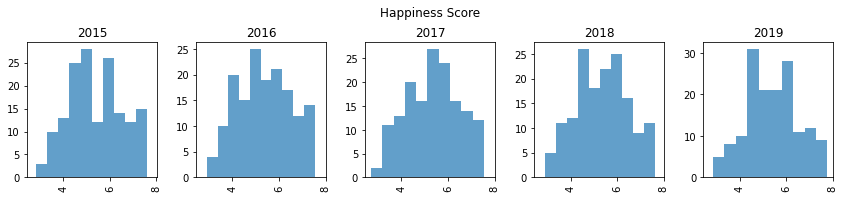

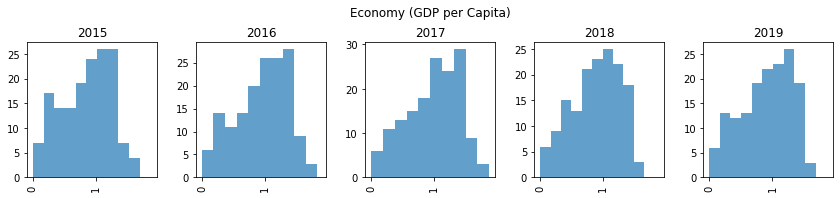

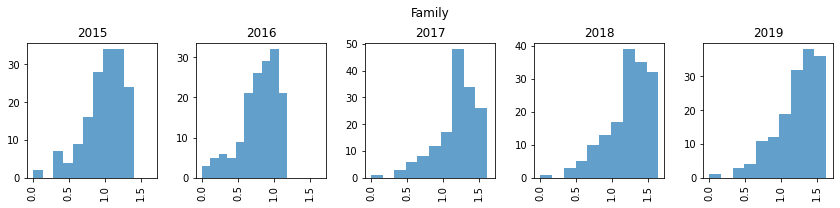

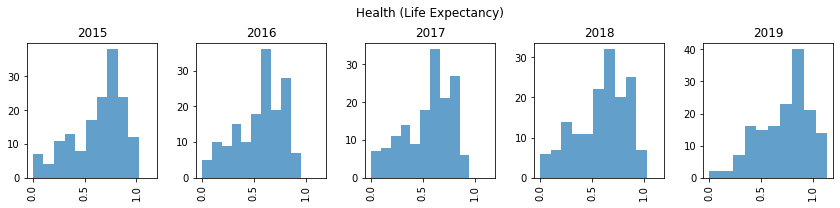

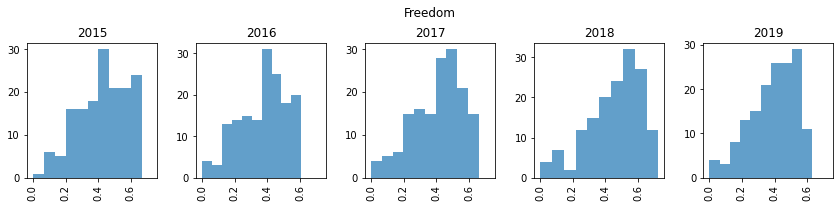

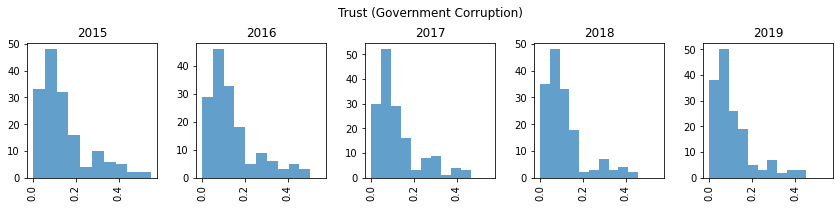

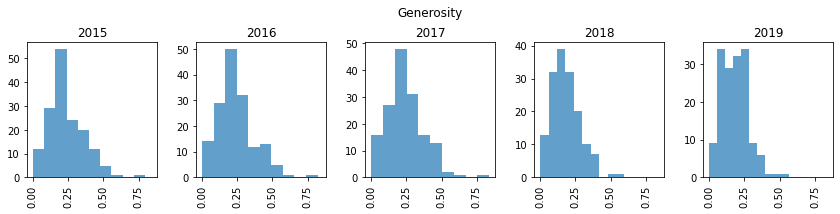

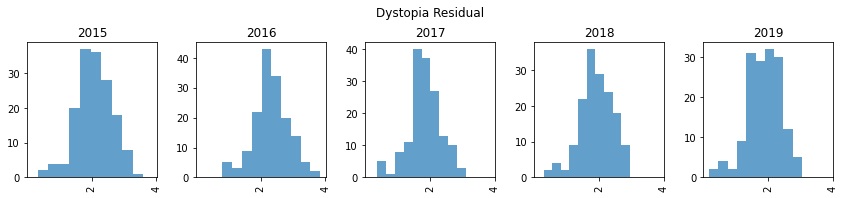

In [113]:
# plot the distribution of each factor by report date
for col in data.iloc[:,4:].columns:
    data[col].hist(by=data['Year'],layout=(1,5),figsize=(14,2.5), sharex=True, alpha=0.7)
    plt.suptitle(col,y=1.1)

The graphs above show the distribution of each of the variables on interest by report date. We can see that the distribution of each variable remains largely constant across time, which confirms the impression we had from the descriptive statistics tables. The histograms suggest that the distribution for the happiness score and those for the contribution from the generosity factor and the residual are normal. While the distributions of the contribution from economic performance, social support, life expectancy and freedom are left skewed, that of the contribution from low corruption is right skewed.

##### Geography dimension

In [114]:
# summary statistics of main factor by report date
for col in data.iloc[:,4:].columns:
    print('\033[1m Summary statistics: \033[0m'+ col)
    display(data.groupby('Region')[col].describe())

 Summary statistics: Happiness Score


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Australia and New Zealand,10.0,7.294600,0.030787,7.228,7.28400,7.2965,7.31375,7.334
Central and Eastern Europe,145.0,5.427807,0.585201,4.096,5.12900,5.4880,5.84800,6.852
Eastern Asia,30.0,5.651567,0.479466,4.874,5.25275,5.6545,5.92075,6.446
Latin America and Caribbean,111.0,6.023811,0.721001,3.582,5.74750,6.1250,6.46500,7.226
Middle East and Northern Africa,95.0,5.322084,1.016752,3.006,4.69400,5.2540,6.20850,7.278
North America,10.0,7.174700,0.204057,6.886,7.02075,7.1985,7.32500,7.427
Southeastern Asia,44.0,5.335227,0.801819,3.819,4.77200,5.2705,6.02400,6.798
Southern Asia,35.0,4.580657,0.587753,3.203,4.34050,4.5650,5.04650,5.653
Sub-Saharan Africa,196.0,4.190153,0.598109,2.693,3.77475,4.2065,4.56200,5.891


 Summary statistics: Economy (GDP per Capita)


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Australia and New Zealand,10.0,1.356197,0.074213,1.25018,1.310645,1.350330,1.397280,1.484415
Central and Eastern Europe,145.0,1.018488,0.221551,0.39047,0.886000,1.064578,1.184980,1.352682
Eastern Asia,30.0,1.237695,0.206102,0.82819,1.028100,1.297500,1.394477,1.551675
Latin America and Caribbean,111.0,0.941661,0.217405,0.26673,0.814690,0.981240,1.092500,1.361356
Middle East and Northern Africa,95.0,1.092177,0.328169,0.28700,0.883400,1.052660,1.349055,1.870766
North America,10.0,1.422037,0.073604,1.32629,1.372378,1.415500,1.469441,1.546259
Southeastern Asia,44.0,0.893340,0.347782,0.27108,0.681605,0.809585,1.098190,1.692278
Southern Asia,35.0,0.638813,0.204443,0.31982,0.446130,0.652000,0.794111,1.009850
Sub-Saharan Africa,196.0,0.448124,0.295533,0.00000,0.257590,0.375648,0.606500,1.198210


 Summary statistics: Family


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Australia and New Zealand,10.0,1.424368,0.182118,1.10476,1.311840,1.529021,1.554799,1.601000
Central and Eastern Europe,145.0,1.172368,0.288634,0.19249,1.002320,1.226680,1.434379,1.584000
Eastern Asia,30.0,1.199232,0.221710,0.72194,1.064447,1.211500,1.410391,1.531000
Latin America and Caribbean,111.0,1.187033,0.243328,0.29561,1.023380,1.236000,1.402300,1.522000
Middle East and Northern Africa,95.0,0.995755,0.305817,0.14866,0.809450,1.039000,1.253349,1.559000
North America,10.0,1.357991,0.173800,1.04782,1.265985,1.438460,1.478762,1.532000
Southeastern Asia,44.0,1.093673,0.250488,0.53750,0.904258,1.122618,1.279280,1.463000
Southern Asia,35.0,0.803835,0.363972,0.11037,0.527000,0.810000,1.141617,1.340127
Sub-Saharan Africa,196.0,0.845690,0.300673,0.00000,0.663470,0.886335,1.068213,1.410000


 Summary statistics: Health (Life Expectancy)


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Australia and New Zealand,10.0,0.903074,0.076916,0.816760,0.845715,0.892185,0.926170,1.036
Central and Eastern Europe,145.0,0.696532,0.102686,0.437726,0.631320,0.701289,0.763760,0.953
Eastern Asia,30.0,0.862612,0.155177,0.554690,0.794401,0.896607,0.962785,1.122
Latin America and Caribbean,111.0,0.676074,0.134685,0.274940,0.596304,0.687410,0.777290,0.963
Middle East and Northern Africa,95.0,0.665518,0.129188,0.310081,0.596740,0.660150,0.747580,1.029
North America,10.0,0.861086,0.076661,0.774287,0.821150,0.848174,0.890500,1.039
Southeastern Asia,44.0,0.635452,0.183888,0.382910,0.489874,0.630330,0.711235,1.141
Southern Asia,35.0,0.513089,0.142957,0.173440,0.453169,0.527000,0.594820,0.831
Sub-Saharan Africa,196.0,0.283879,0.153401,0.000000,0.180750,0.290439,0.376417,0.798


 Summary statistics: Freedom


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Australia and New Zealand,10.0,0.611413,0.038675,0.55700,0.582352,0.607835,0.645095,0.66900
Central and Eastern Europe,145.0,0.352233,0.129544,0.09245,0.258830,0.346000,0.437454,0.72400
Eastern Asia,30.0,0.418185,0.107299,0.15900,0.353180,0.438130,0.494855,0.59700
Latin America and Caribbean,111.0,0.464330,0.125081,0.02500,0.431726,0.489270,0.542990,0.63376
Middle East and Northern Africa,95.0,0.349360,0.156041,0.00000,0.241000,0.324000,0.462867,0.65400
North America,10.0,0.558918,0.064998,0.45400,0.515815,0.560350,0.604326,0.65300
Southeastern Asia,44.0,0.543723,0.078021,0.35600,0.504883,0.552920,0.594807,0.69600
Southern Asia,35.0,0.392867,0.159702,0.00000,0.323500,0.440306,0.517085,0.58500
Sub-Saharan Africa,196.0,0.353638,0.140003,0.00000,0.290327,0.379895,0.448280,0.67400


 Summary statistics: Trust (Government Corruption)


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Australia and New Zealand,10.0,0.357294,0.050605,0.290000,0.307327,0.368185,0.387454,0.42922
Central and Eastern Europe,145.0,0.075680,0.080733,0.000000,0.024211,0.040904,0.111320,0.38331
Eastern Asia,30.0,0.117992,0.100305,0.022794,0.041250,0.078285,0.160321,0.37124
Latin America and Caribbean,111.0,0.092432,0.046778,0.008965,0.060184,0.086000,0.116135,0.24558
Middle East and Northern Africa,95.0,0.144670,0.098356,0.027000,0.083020,0.114381,0.159515,0.52208
North America,10.0,0.223345,0.088123,0.128000,0.138899,0.223136,0.303750,0.32957
Southeastern Asia,44.0,0.136140,0.134696,0.000000,0.052218,0.095071,0.175000,0.49210
Southern Asia,35.0,0.100357,0.039417,0.025000,0.073315,0.092227,0.125760,0.17338
Sub-Saharan Africa,196.0,0.105985,0.082574,0.025336,0.060000,0.085410,0.117419,0.55191


 Summary statistics: Generosity


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Australia and New Zealand,10.0,0.424441,0.069565,0.330000,0.362000,0.454845,0.477027,0.500005
Central and Eastern Europe,145.0,0.157000,0.087545,0.001990,0.086800,0.144430,0.209510,0.428580
Eastern Asia,30.0,0.199801,0.111852,0.028807,0.103442,0.197457,0.257238,0.400970
Latin America and Caribbean,111.0,0.185378,0.092826,0.042500,0.114255,0.175000,0.231335,0.489204
Middle East and Northern Africa,95.0,0.178190,0.111618,0.026000,0.095000,0.148000,0.255500,0.493664
North America,10.0,0.372339,0.070902,0.280000,0.298500,0.396814,0.429347,0.458110
Southeastern Asia,44.0,0.384195,0.182852,0.117000,0.250540,0.352483,0.502337,0.838075
Southern Asia,35.0,0.300888,0.103531,0.153000,0.214110,0.307000,0.367550,0.490864
Sub-Saharan Africa,196.0,0.207592,0.079652,0.025000,0.168452,0.206000,0.245000,0.514790


 Summary statistics: Dystopia Residual


,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Australia and New Zealand,10.0,2.217841,0.171810,2.046456,2.101250,2.147500,2.265907,2.54650
Central and Eastern Europe,145.0,1.955488,0.447865,0.814382,1.677000,1.917000,2.246390,3.38007
Eastern Asia,30.0,1.616093,0.554107,0.554633,1.369668,1.635675,2.028000,2.61523
Latin America and Caribbean,111.0,2.476883,0.510419,1.213050,2.166660,2.509586,2.836577,3.60214
Middle East and Northern Africa,95.0,1.896425,0.517485,0.328580,1.587620,1.854000,2.211535,3.40904
North America,10.0,2.378992,0.207980,2.187264,2.220335,2.285500,2.495522,2.72782
Southeastern Asia,44.0,1.648712,0.480208,0.651000,1.367500,1.622270,2.011264,2.57960
Southern Asia,35.0,1.830773,0.727544,0.419389,1.378500,1.829160,2.235565,3.18286
Sub-Saharan Africa,196.0,1.945231,0.579118,0.184000,1.637570,1.943480,2.311892,3.83772


The tables above show the descriptive statistics for each variable of interest by region. As expected, the sample size changes by regions, as more or less countries fall into the defined geographical boundaries. Because the sample sime for some regions (e.g. Australia and New Zealand, North America and Eastern Asia) is small, the analysis by region may suffer from sample size bias. Overall, the descriptive statistics indicate more variation in the average happiness score and the average contribution from each of the six main factors by region, compared to the time dimension. 

#### Correlations among variables of interest

#### Predictive model

In this section, we use a linear regression model to estimate the happiness score based on the contribution from the 

In [111]:
# Initialize the regression model
y = data['Happiness Score']
x = data.iloc[:,5:]
#x = sm.add_constant(x)

model = sm.OLS(y,x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Happiness Score   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.762e+10
Date:                Sat, 01 Aug 2020   Prob (F-statistic):                        0.00
Time:                        17:33:55   Log-Likelihood:                          5461.7
No. Observations:                 781   AIC:                                 -1.091e+04
Df Residuals:                     774   BIC:                                 -1.088e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Economy (GDP per Capita)          1.0000   3.41e-05   2.93e+04      0.000       1.000       1.000
Family                            1.0000   2.99e-05   3.34e+04      0.000       1.000       1.000
Health (Life Expectancy)          0.9999   5.34e-05   1.87e+04      0.000       1.000       1.000
Freedom                           1.0000   6.65e-05    1.5e+04      0.000       1.000       1.000
Trust (Government Corruption)     0.9999   9.07e-05    1.1e+04      0.000       1.000       1.000
Generosity                        1.0001   6.76e-05   1.48e+04      0.000       1.000       1.000
Dystopia Residual                 1.0000   1.04e-05   9.59e+04      0.000       1.000       1.000
==============================================================================
Omnibus:                        0.923   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.630   Jarque-Bera (JB):                0.869
Skew:                          -0.081   Prob(JB):                        0.648
Kurtosis:                       3.016   Cond. No.                         32.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion